## Resting-state epoch identification using K-means clustering on EEG/EMG derived PSD features

This notebook demonstrates how k-means clustering can be used to separate distinct types of epochs. Here, the goal was to identify
epochs that lie in between sleep and active states through from EEG (OFC_L) and EMG derived features.

Such an approach can nonetheless be used to basically separate many kind of distinct epochs, that is, if you can visually separate them
by eye when investigating a certain epoch's EMG and EEG signals.

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mne.time_frequency import psd_array_multitaper

from settings_general import *
from resting_state.settings import *
from shared.helper_functions import select_folder

Let's select the folder that holds epoch files that start with 'filtered_epochs_w_movement_'

In [ ]:
epochs_folder = select_folder("Select folder containing epoch files starting with 'filtered_epochs_w_movement'")

Let's define two functions that calculate features from either EEG or EMG signal traces

In [2]:
def calculate_emg_psd_features(signal, sfreq):
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=sfreq, n_jobs=-1, verbose=False)

    psds = {}  # slice psd data of epoch based on the defined bands
    for band, (start, end) in freq_bands_emg.items():
        slice_start, slice_end = int(start / 100 * len(freq)), int(end / 100 * len(freq))
        psd_slice = psd[slice_start:slice_end]

        psds[f"EMG {band}"] = np.mean(np.log(psd_slice))

    psds['EMG high-low freq ratio'] = ((psds['EMG band9'] + psds['EMG band10']) / (psds['EMG band1'] + psds['EMG band2']))

    return psds

def calculate_eeg_psd_features(signal, sfreq):
    eeg_psds = {}
    for band, (start, end) in freq_bands_eeg.items():
        psd, freq = psd_array_multitaper(signal, fmin=start, fmax=end, sfreq=sfreq, n_jobs=-1)

        eeg_psds[f"OFC_L {band}"] = np.mean(np.log(psd))

    eeg_psds['gamma-delta ratio'] = (eeg_psds['OFC_L $\\gamma$'] / eeg_psds['OFC_L $\\delta$'])
    return eeg_psds

And then the general function that's used to engineer features for epoch clustering. 

In [3]:
def engineer_features(non_mov_epochs, wanted_chans):
    """
    Engineers desired features for the given subject. If there are two quality EMG channels,
    then the features derived from both EMG channels are averaged.

    :param non_mov_epochs: the subject's epochs
    :param wanted_chans: indexes used to retrieve right epoch data (one EEG channel, and one EMG channel)
    :return:
    """
    print(f'Engineering features..')

    sfreq = non_mov_epochs.info['sfreq']
    all_features = []  # list holding dict with all features per epoch

    # loop through the epochs in the subject's epochs
    for i, epoch in enumerate(non_mov_epochs):
        # features per epoch are stored in here
        features = {
            'subject_id': non_mov_epochs.metadata['animal_id'].iloc[0],
            'epoch_n': non_mov_epochs.metadata.iloc[i].name,
            'movement': non_mov_epochs.metadata["movement"].iloc[i],
            'frame_start_end': non_mov_epochs.metadata["epochs_start_end_frames"].iloc[i]
        }

        # for all wanted_chans, calculate the desired features
        for chan_type, chan_index in wanted_chans.items():
            if chan_type == 'EEG':
                # we only wish to calc PSD features using one chan, so get first index and then the data
                eeg_chan_data = epoch[chan_index, :]
                # get eeg psd features with right data from epoch
                features.update(calculate_eeg_psd_features(eeg_chan_data, sfreq))

            # if the looped channel type we need to calc features for is EMG, then we end up here
            if chan_type == 'EMG':

                # if there's only one EMG channel, save its features
                channel_data = epoch[chan_index, :]
                features.update(calculate_emg_psd_features(channel_data, sfreq))

        # store this epoch's features in the list
        all_features.append(features)

    print(f'Done engineering features.')

    return pd.DataFrame(all_features)

A function that retrieves the channel names that we want to engineer features for.

In [4]:
def get_wanted_chans(subject_epochs, subject_id):
    wanted_eeg_chan = 'OFC_L'
    wanted_emg_chan = quality_emg[int(subject_id)]
    recorded_chans = subject_epochs.info['ch_names']
    wanted_chan_indexes = {
        'EEG': [index for index, value in enumerate(recorded_chans) if value == wanted_eeg_chan][0],
        'EMG': [index for index, value in enumerate(recorded_chans) if value == wanted_emg_chan][0]
    }
    return wanted_chan_indexes

A function that uses DBSCAN for outlier/anomaly removal. Uses a hard-coded cutoff for the amount of epochs needed. Change the DBSCAN arguments to your liking.

In [5]:
def remove_cluster_outliers(df_numeric, df_plot):
    # hard-coded cutoff for animals that already have a relatively low amount of epochs
    if df_numeric.shape[0] < 400:
        return df_numeric, df_plot

    dbscan = DBSCAN(eps=2.4, min_samples=35)
    outlier_preds = dbscan.fit_predict(df_numeric)

    df_plot['outlier'] = outlier_preds
    print("Number of outliers: ", len(outlier_preds[outlier_preds == -1]))
    
    # show outliers
    fig = plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_plot, x=0, y=1, hue="outlier", palette=sns.color_palette("husl"))
    plt.title("Clusters by PCA components, non-movement epochs")
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")
    plt.show()
    
    # remove outliers
    df_numeric_wo_outliers = df_numeric[~df_plot['outlier'].isin([-1])]
    df_plot_wo_anomalies = df_plot[~df_plot['outlier'].isin([-1])]

    return df_numeric_wo_outliers, df_plot_wo_anomalies

And a plotting function to get handy insights into what kind of epochs each cluster holds.

In [6]:
def plot_cluster_insights(features, df_plot):
    
    clusters = np.unique(df_plot["cluster"])
    row_len = int(np.ceil(len(clusters) / 2)) + 1
    col_len = int(np.ceil(len(clusters) / row_len)) + 1
    palette = sns.color_palette("husl", 3).as_hex()
    
    # CREATE PLOTTING GRID USING PLOTLY
    
    fig = make_subplots(
        rows=row_len, cols=col_len,
        specs=[[{'type': 'polar'}, {'type': 'polar'}], [{'type': 'polar'}, {'type': 'scatter'}], [{"colspan": 2}, None]],
        horizontal_spacing=0.08, vertical_spacing=0.12,
        shared_yaxes=True, shared_xaxes=True,
        subplot_titles=["Cluster 0", "Cluster 1", "Cluster 2", "Clusters by PCA components, non-movement epochs", "Boxplot of (min-max scaled) feature distribution per cluster"]
    )
    
    # LOOP THROUGH CLUSTERS AND GENERATE RADAR PLOTS AND BOX-PLOTS
    
    max_value = 0
    fig_box = go.Figure()  # for storing boxplot per cluster
    
    for i, cluster in enumerate(clusters):
        cluster_features = features[df_plot["cluster"] == cluster]
        cluster_features = cluster_features.drop(columns=['gamma-delta ratio', 'EMG high-low freq ratio'])
        
        row, col = (i // 2) + 1, (i % 2) + 1

        average_features = cluster_features.mean(axis=0)
        
        max_value = np.max(average_features) if np.max(average_features) > max_value else max_value
            
        fig.add_trace(go.Scatterpolar(
            r=average_features,
            theta=average_features.index,
            fill='toself',
            name=f'Cluster {i}',
            showlegend=False
        ), row=row, col=col)
        
        # add boxplot trace for this cluster as well
        cluster_features = cluster_features.drop(columns=['EMG band3', 'EMG band4', 'EMG band5', 'EMG band6', 'EMG band7', 'EMG band8'])
        repeated_arrays = [np.repeat(feature, len(cluster_features)) for feature in cluster_features.columns]
        x = np.concatenate(repeated_arrays)
        y = cluster_features.T.stack().values
        
        # per add_trace alle data van 1 cluster en splits het dmv de x op features
        fig_box.add_trace(go.Violin(
            y=y,
            x=x,
            name=f'Cluster {cluster}',
            marker_color=palette[cluster],
            showlegend=True
        ))

    fig_box.update_traces(box_visible=True, meanline_visible=True)
    # add the boxplot to the grid plot
    for trace in fig_box.data:
        fig.add_trace(trace, row=3, col=1)
    
    
    # ADD CLUSTER PLOT TO ROW 2 COL 2 OF GRID
    
    fig.add_trace(go.Scatter(
        x=df_plot[0], y=df_plot[1], mode="markers", 
        marker=dict(color=df_plot["cluster"], colorscale=palette),
        showlegend=False
    ), row=2, col=2)
    fig.update_xaxes(title_text="Principle Component 1", row=2, col=2)
    fig.update_yaxes(title_text="Principle Component 2", row=2, col=2)

    # COMPLETE FIGURE
    fig.update_layout(
        height=400*row_len, width=620*col_len,
        margin=dict(l=50, r=50, t=140, b=70),
        colorway=palette,
        showlegend=True,
        violinmode='group',
        violingap=0.3,
        violingroupgap=0.1
    )
    fig.update_annotations(yshift=20)
    fig.update_polars(radialaxis=dict(range=[0, max_value+.05]))
    fig.show()

## Epoch clustering for subject 39508 (WT)

In [73]:
epochs_39508 = mne.read_epochs(os.path.join(epochs_folder, "filtered_epochs_w_movement_39508-epo.fif"), preload=True)
epochs_39508 = epochs_39508[:-1]  # somehow the last epoch holds only zeros
epochs_39508.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3207
Events,1: 3207
Time range,0.000 – 4.999 s
Baseline,off


In [74]:
non_mov_39508 = epochs_39508[epochs_39508.metadata['movement'] == 0]
features_39508 = engineer_features(non_mov_39508, get_wanted_chans(epochs_39508, '39508'))

Engineering features..
Done engineering features.


In [75]:
df_numeric = features_39508.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(389, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-13.580723,-14.346173,-14.237211,-16.844413,-17.501651,1.288713,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485,1.127797
1,-12.708286,-13.251085,-14.909869,-16.759986,-17.782877,1.399314,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427,1.123900
2,-13.000937,-12.513695,-15.146621,-16.703464,-17.720422,1.363011,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775,1.151028
3,-12.857127,-13.332727,-14.892472,-16.905170,-17.745892,1.380238,-15.666305,-17.603781,-17.672099,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657,1.122091
4,-12.809237,-13.280218,-14.513769,-16.761566,-17.275025,1.348638,-15.376889,-17.518799,-18.421073,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330,1.147908


Perform PCA

In [76]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_39508.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

In [77]:
print(df_numeric.shape)
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features_39508 = scaler.fit_transform(df_numeric)

# using the rescaled data without the outliers, perform PCA again
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features_39508)
df_plot[0] = comp[:, 0]  # replace the components
df_plot[1] = comp[:, 1]

(389, 17)
(389, 17)


In [78]:
kmeans_39508 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_39508.fit(scaled_features_39508)

print(f'Clusters with sizes of: {np.unique(kmeans_39508.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans_39508.labels_

Clusters with sizes of: [211  26 152]


### Show cluster insights

In [79]:
plot_cluster_insights(scaled_features, df_plot)

## Epoch clustering for subject 80625 (KO)

In [19]:
epochs_80625 = mne.read_epochs(os.path.join(epochs_folder, "filtered_epochs_w_movement_80625-epo.fif"), preload=True)
epochs_80625 = epochs_80625[:-1]  # somehow the last epoch holds only zeros
epochs_80625.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,1544
Events,1: 1544
Time range,0.000 – 4.999 s
Baseline,off


In [20]:
non_mov_80625 = epochs_80625[epochs_80625.metadata['movement'] == 0]
features_80625 = engineer_features(non_mov_80625, get_wanted_chans(epochs_80625, '80625'))

Engineering features..
Done engineering features.


In [48]:
df_numeric = features_80625.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(898, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-15.826677,-16.365108,-15.946520,-18.029519,-18.899249,1.194139,-16.069324,-17.425135,-18.056118,-18.119496,-18.151192,-18.683983,-18.698573,-18.501623,-18.583025,-17.946377,1.090610
1,-15.567960,-15.691947,-16.063244,-17.421022,-18.753765,1.204639,-15.709721,-17.559035,-18.094597,-18.470368,-18.513797,-18.823047,-18.310157,-18.697271,-18.707440,-18.529400,1.119274
2,-15.047281,-15.192003,-16.372403,-17.978878,-18.718807,1.243999,-15.899201,-17.709568,-18.518964,-18.347886,-18.781456,-18.906762,-18.420800,-18.558848,-18.659125,-18.659062,1.110371
3,-15.477481,-15.116941,-16.414383,-17.502805,-18.703929,1.208461,-16.045884,-17.603680,-18.338061,-18.568886,-19.059590,-19.078569,-18.733511,-18.803696,-18.719771,-18.948368,1.119424
4,-15.571145,-15.174178,-15.867502,-17.701516,-18.704417,1.201223,-15.910047,-17.834114,-18.429282,-18.390033,-18.463950,-18.517219,-18.528908,-18.796042,-18.943453,-18.633807,1.113593


Perform PCA

In [49]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_80625.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

Remove outliers, rescale the remaining data, and fit PCA again.

(898, 17)
Number of outliers:  6


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1804/3960416708.py:14: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



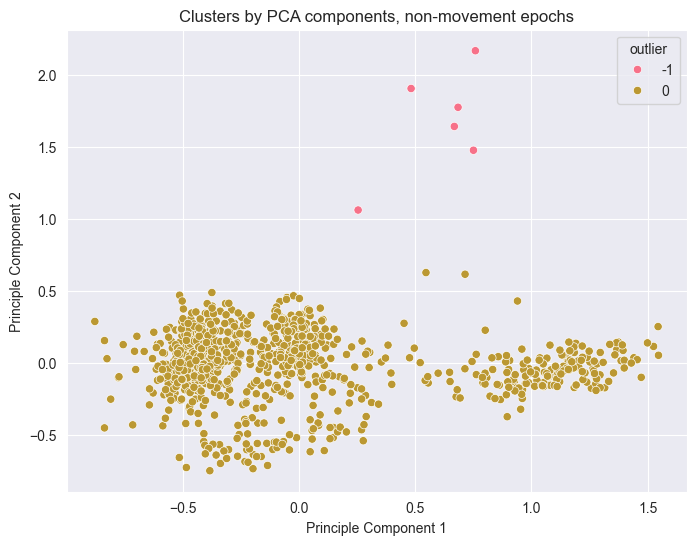

(892, 17)


In [51]:
print(df_numeric.shape)
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features_80625 = scaler.fit_transform(df_numeric)

# using the rescaled data without the outliers, perform PCA again
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features_80625)
df_plot[0] = comp[:, 0]  # replace the components
df_plot[1] = comp[:, 1]

In [58]:
kmeans_80625 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_80625.fit(scaled_features_80625)

print(f'Clusters with sizes of: {np.unique(kmeans_80625.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans_80625.labels_

Clusters with sizes of: [598 168 126]


### Show cluster insights

In [59]:
plot_cluster_insights(scaled_features_80625, df_plot)

## Epoch clustering for subject 79602 (WT)

In [7]:
epochs_79602 = mne.read_epochs(os.path.join(epochs_folder, "filtered_epochs_w_movement_79602-epo.fif"), preload=True)
epochs_79602 = epochs_79602[:-1]  # somehow the last epoch holds only zeros
epochs_79602.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3050
Events,1: 3050
Time range,0.000 – 4.999 s
Baseline,off


In [9]:
non_mov_79602 = epochs_79602[epochs_79602.metadata['movement'] == 0]
features_79602 = engineer_features(non_mov_79602, get_wanted_chans(epochs_79602, '79602'))

Engineering features..
Done engineering features.


In [10]:
df_numeric = features_79602.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(614, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-13.454676,-12.964446,-14.419840,-16.793435,-17.645603,1.311485,-15.884278,-17.430349,-17.754259,-17.945781,-18.173068,-18.599857,-18.915776,-18.755629,-19.082144,-18.986367,1.142697
1,-13.293052,-13.950133,-13.881056,-16.837383,-17.361049,1.306024,-15.734149,-17.421627,-18.065276,-17.997148,-17.573040,-18.271510,-18.719836,-18.771765,-18.779137,-18.911567,1.136776
2,-13.161084,-12.900051,-14.338678,-16.780541,-17.535354,1.332364,-15.587428,-17.641862,-18.043255,-18.090677,-17.985102,-18.442812,-18.203042,-18.987113,-18.967506,-18.977530,1.141915
3,-13.654374,-14.553821,-13.740323,-16.936793,-17.286539,1.266007,-15.804059,-17.022455,-17.126551,-17.071565,-17.406413,-17.873255,-17.413785,-17.657101,-18.171353,-18.274364,1.110252
4,-13.391768,-14.264439,-13.913758,-17.133251,-17.600925,1.314309,-15.867851,-17.663962,-18.151790,-17.803347,-18.113021,-18.579428,-18.386750,-18.579616,-18.739582,-18.629629,1.114441


In [11]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_79602.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

(614, 17)
Number of outliers:  41


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_6205/3960416708.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_plot, x=0, y=1, hue="outlier", palette=sns.color_palette("husl"))


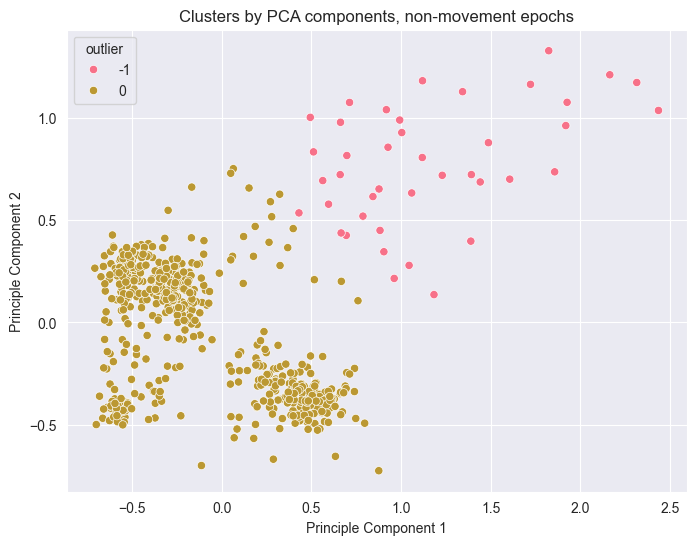

(573, 17)


In [12]:
print(df_numeric.shape)
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features_79602 = scaler.fit_transform(df_numeric)

# using the rescaled data without the outliers, perform PCA again
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features_79602)
df_plot[0] = comp[:, 0]  # replace the components
df_plot[1] = comp[:, 1]

In [13]:
kmeans_79602 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_79602.fit(scaled_features_79602)

print(f'Clusters with sizes of: {np.unique(kmeans_79602.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans_79602.labels_

Clusters with sizes of: [ 66 207 300]


### Show cluster insights

In [86]:
plot_cluster_insights(scaled_features_79602, df_plot)

## Epoch clustering for subject 81193
 
So, for this subject it is somewhat more tricky to get the right clusters. In short, we need to use the n_init argument of KMeans in order to get our desired result, as we know the number of epochs are not equal in each cluster. Sleep and active probably will always hold more epochs than true resting-state behaviour.

Let's see what the differrence is between leaving n_init on 'auto' and us setting it to 10.

In [87]:
epochs_81193 = mne.read_epochs(os.path.join(epochs_folder, "filtered_epochs_w_movement_81193-epo.fif"), preload=True)
epochs_81193 = epochs_81193[:-1]  # somehow the last epoch holds only zeros
epochs_81193.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3206
Events,1: 3206
Time range,0.000 – 4.999 s
Baseline,off


In [88]:
non_mov_81193 = epochs_81193[epochs_81193.metadata['movement'] == 0]
features_81193 = engineer_features(non_mov_81193, get_wanted_chans(epochs_81193, '81193'))

Engineering features..
Done engineering features.


In [89]:
df_numeric = features_81193.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(858, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-14.721515,-15.221412,-15.970793,-17.585578,-18.885722,1.282865,-15.708497,-17.394516,-17.866947,-18.046517,-18.231391,-18.354558,-18.489327,-18.451229,-18.468010,-18.365620,1.112697
1,-15.094341,-14.369485,-15.848996,-17.300044,-18.891663,1.251573,-15.601068,-17.319856,-17.743062,-18.357734,-18.177152,-18.465378,-18.562565,-18.633032,-18.729771,-19.015077,1.146531
2,-15.046749,-15.771104,-15.716501,-17.662621,-18.814472,1.250401,-15.267906,-17.463171,-17.843001,-18.192506,-18.423373,-18.473217,-18.354950,-18.540412,-18.696937,-18.326728,1.131147
3,-15.682511,-15.205827,-15.882768,-17.507793,-18.899962,1.205162,-15.324146,-17.383501,-17.691315,-18.160726,-18.491107,-18.408917,-18.747429,-18.408017,-18.440042,-18.243693,1.121564
4,-15.067952,-14.873328,-15.381507,-17.412142,-18.568249,1.232301,-15.172651,-17.154935,-17.829003,-17.753428,-17.884712,-18.306410,-18.444984,-18.212406,-18.555441,-18.167955,1.135977


Perform PCA

In [90]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_81193.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

(858, 17)
Number of outliers:  2


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_1804/3960416708.py:14: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



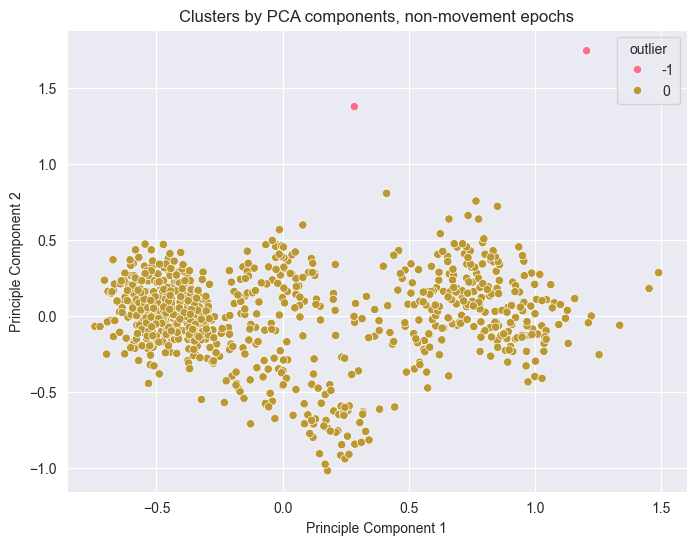

(856, 17)


In [91]:
print(df_numeric.shape)
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features_81193 = scaler.fit_transform(df_numeric)

# using the rescaled data without the outliers, perform PCA again
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features_81193)
df_plot[0] = comp[:, 0]  # replace the components
df_plot[1] = comp[:, 1]

### Show cluster insights

Now, let's show the cluster insights when we do not explicitly set n_init

In [92]:
kmeans_81193 = KMeans(n_clusters=3, random_state=40)
kmeans_81193.fit(scaled_features_81193)

print(f'Clusters with sizes of: {np.unique(kmeans_81193.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans_81193.labels_

Clusters with sizes of: [288 465 103]


In [93]:
plot_cluster_insights(scaled_features_81193, df_plot)

And now, let's initialize the centroids more often, and see to where the centroids converge then.

In [94]:
kmeans_81193 = KMeans(n_clusters=3, n_init=10, random_state=40)
kmeans_81193.fit(scaled_features_81193)

print(f'Clusters with sizes of: {np.unique(kmeans_81193.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans_81193.labels_

Clusters with sizes of: [247 516  93]


In [95]:
plot_cluster_insights(scaled_features_81193, df_plot)

We can see that this makes a huge difference. We will use n_init=10 going forward.